In `nb/max_entropy_prior_correction.ipynb`, I struggled to impose flat priors on ${\rm SSFR}_{1Gyr}$ and ${\rm SSFR}_{100Myr}$ simultaneously. I suspect this is due to the highly correlated joint distribution $p({\rm SSFR}_{1Gyr}, {\rm SSFR}_{100Myr})$. Perhaps it will be less challenging to impose flat priors on a less correlated joint distribution: $p({\rm SSFR}_{1Gyr}, Z)$

In [1]:
import os, h5py
import numpy as np 
import corner as DFM 
import wquantiles as wq
from scipy.stats import gaussian_kde as gkde
from sklearn.mixture import GaussianMixture as GMix
# --- gpc_mc --- 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
np.random.seed(0)

Sample SFH basis coefficients $\{b_i\}$ from Dirichlet prior using the warped manifold transformation. Sampling ZH basis coefficients $\{\gamma_i\}$ from $U(6.9\times10^{-5}, 7.3\times10^{-3})$

In [4]:
n_sample = 100000
bp1 = np.random.uniform(size=n_sample)
bp2 = np.random.uniform(size=n_sample)
bp3 = np.random.uniform(size=n_sample)
bp4 = np.random.uniform(size=n_sample)

ispec = Fitters.iSpeculator()

# warped manifold transform
beta_arr = ispec._transform_to_SFH_basis(np.array([bp1, bp2, bp3, bp4]).T)
# betas
b1, b2, b3, b4 = beta_arr.T

In [5]:
g1 = 6.9e-5 + (7.3e-3 - 6.9e-5) * np.random.uniform(size=n_sample)
g2 = 6.9e-5 + (7.3e-3 - 6.9e-5) * np.random.uniform(size=n_sample) 

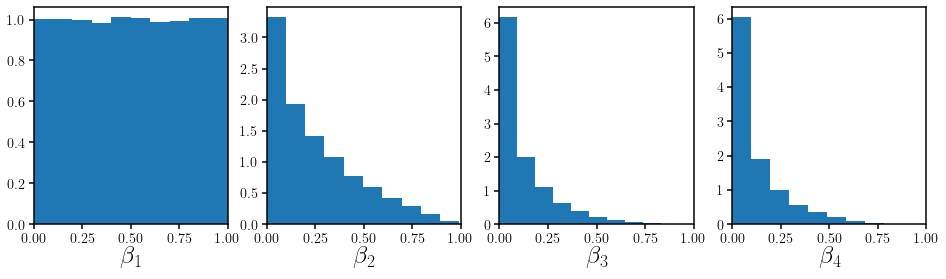

In [6]:
fig = plt.figure(figsize=(16,4))
for i, _y in enumerate([b1, b2, b3, b4]): 
    sub = fig.add_subplot(1,4,i+1)
    sub.hist(_y, density=True)
    sub.set_xlim(0., 1)
    sub.set_xlabel(r'$\beta_{%i}$' % (i+1), fontsize=25)

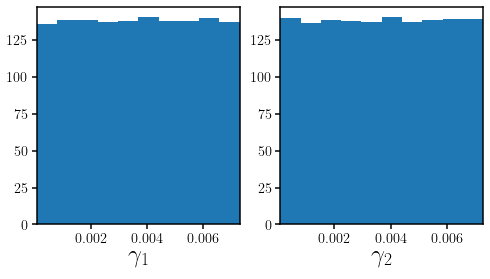

In [7]:
fig = plt.figure(figsize=(8,4))
for i, _y in enumerate([g1, g2]): 
    sub= fig.add_subplot(1,2,i+1)
    sub.hist(_y, density=True)
    sub.set_xlim(6.9e-5, 7.3e-3)
    sub.set_xlabel(r'$\gamma_{%i}$' % (i+1), fontsize=25)

Now lets calculate the derived properties ${\rm SSFR}_{100Myr}$ and ${\rm SSFR}_{1Gyr}$ from the sampled $\{\beta_i\}$

In [8]:
thetas = np.array([np.ones(len(b1)), b1, b2, b3, b4, g1, g2])

In [9]:
ssfr_1gyr = ispec.get_SFR(thetas, 0.1, dt=1.)
logssfr_1gyr = np.log10(ssfr_1gyr)

In [10]:
z_mw = ispec.get_Z_MW(thetas, 0.1)

Here's what $P( {\rm SSFR}\,|\,p_{\rm Dirichlet}(\beta_i))$ and $P( Z\,|\,U(\gamma_i))$ look like

(0.0, 0.04)

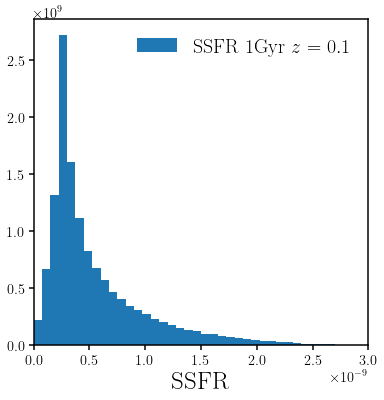

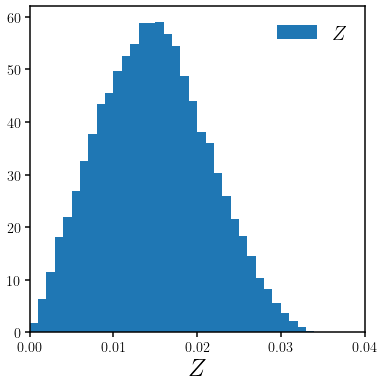

In [11]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(z_mw, range=(0., 0.04), bins=40, density=True, label='$Z$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$Z$', fontsize=25)
sub.set_xlim(0., 0.04)

Here's how the joint distribution looks like

(0.0, 0.04)

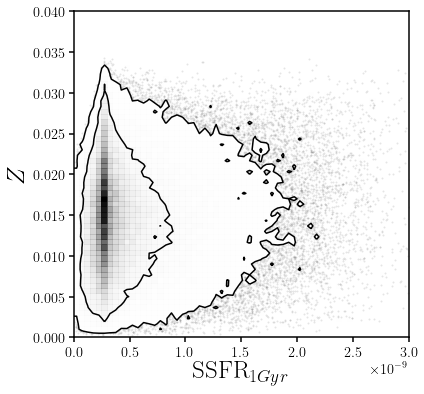

In [12]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

DFM.hist2d(ssfr_1gyr, z_mw, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 0.04]], bins=60,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0., 3e-9)
sub.set_ylabel(r'$Z$', fontsize=25)
sub.set_ylim(0., 0.04)

Lets fit a KDE to the distribution above and check that it looks reasonable

In [13]:
X = np.array([ssfr_1gyr * 1e9, z_mw]).T

In [14]:
kde_fit = gkde(X.T)

In [15]:
_kde_samples = kde_fit.resample(10000)
_kde_samples[0] *= 1e-9

(0.0, 0.04)

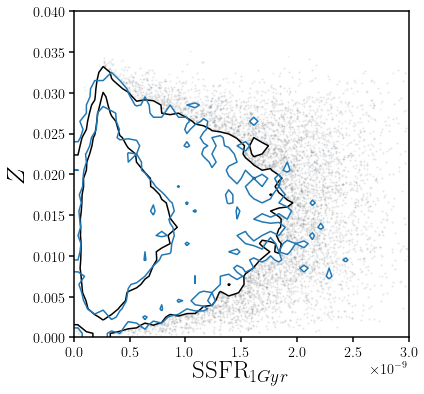

In [16]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

DFM.hist2d(ssfr_1gyr, z_mw, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 0.04]], bins=40,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 

DFM.hist2d(_kde_samples[0,:], _kde_samples[1,:], color='C0', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 0.04]], bins=40, 
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 

sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0., 3e-9)
sub.set_ylabel(r'$Z$', fontsize=25)
sub.set_ylim(0., 0.04)

Much simpler distribution to fit than $p({\rm SSFR}_{1Gyr}, {\rm SSFR}_{100Myr})$. Lets see if the maximum entropy priors using the factor

$$\frac{1}{P({\rm SSFR}_{1Gyr}, Z\,|\, p_{\rm Dirichlet}(\beta), U(\gamma))}$$

imposes uniform priors on both ${\rm SSFR}_{1Gyr}$ and $Z$

In [18]:
w_kde = 1./kde_fit.pdf(X.T)

(0.0, 0.04)

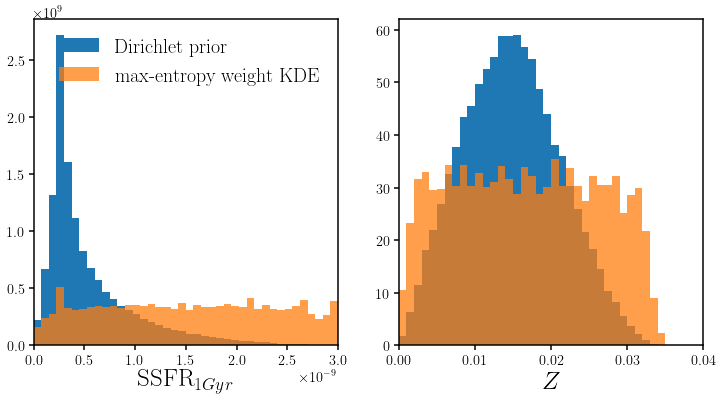

In [19]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(122)
sub.hist(z_mw, range=[0, 0.04], bins=40, density=True, label='Dirichlet prior')
sub.hist(z_mw, weights=w_kde, range=[0, 0.04], bins=40, density=True, alpha=0.75)

sub.set_xlabel(r'$Z$', fontsize=25)
sub.set_xlim(0, 0.04)